In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
%matplotlib inline



### RECOMMENDATION

- close all applications
- install Maxthon browser http://www.maxthon.com
- open only VirtualBox and Maxthon


## Batch Normalization

See 

- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)

- [Batch normalization: theory and how to use it with Tensorflow](https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad)

- [CS231n Convolutional Neural Networks](http://cs231n.github.io/neural-networks-2/)


**We are using a small dataset based on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**

In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [3]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

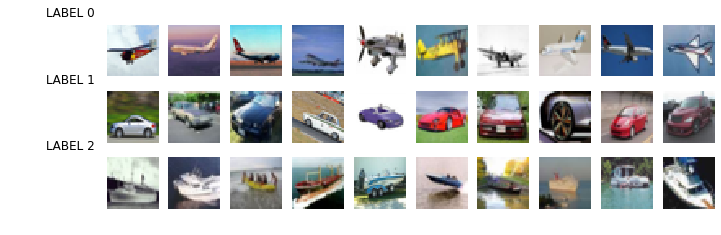

In [4]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [6]:
print(np.min(x_cifar), np.max(x_cifar))

0.0 1.0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
num_classes = len(np.unique(y_train))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())
print("\nnum classes", num_classes)

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    777
0    750
1    726
dtype: int64

distribution of test classes
0    255
2    248
1    248
dtype: int64

num classes 3


## Set up a model with Keras and train

In [10]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    def norm_init(shape, dtype=None, partition_info=None):
        return tf.keras.backend.random_normal(shape, mean=0.0, stddev=0.01, dtype=dtype)
    
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(4,4), activation="relu", padding="same", 
                                    kernel_initializer=norm_init,
                                    bias_initializer=norm_init)(inputs)
        
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu, 
                                   kernel_initializer=norm_init,
                                   bias_initializer=norm_init)(layers)
    
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [11]:
model = get_conv_model_A(num_classes)
model.summary()
print("\n--- weights ---")
for w in model.get_weights():
    print((w.shape))

using 3 classes
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 15)        735       
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                245776    
_________________________________________________________________
output_1 (Dense)             (None, 3)                 51        
Total params: 246,562
Trainable params: 246,562
Non-trainable params: 0
_________________________________________________________________

--- weights ---
(4, 4, 3, 15)
(15,)
(15360, 16)

In [12]:
def train(model, x_train, y_train, x_test, y_test, batch_size, epochs, model_name=""):
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [13]:
model = get_conv_model_A(num_classes)
train(model, x_train, y_train, x_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 2s 770us/sample - loss: 1.0308 - acc: 0.4430 - val_loss: 0.9485 - val_acc: 0.5060
Epoch 2/30
2253/2253 [==============================] - 2s 697us/sample - loss: 0.9006 - acc: 0.5801 - val_loss: 0.8701 - val_acc: 0.6152
Epoch 3/30
2253/2253 [==============================] - 2s 749us/sample - loss: 0.8371 - acc: 0.6218 - val_loss: 0.9035 - val_acc: 0.5739
Epoch 4/30
2253/2253 [==============================] - 2s 706us/sample - loss: 0.8003 - acc: 0.6462 - val_loss: 0.8038 - val_acc: 0.6391
Epoch 5/30
2253/2253 [==============================] - 2s 826us/sample - loss: 0.7710 - acc: 0.6582 - val_loss: 0.7781 - val_acc: 0.6644
Epoch 6/30
2253/2253 [==============================] - 2s 744us/sample - loss: 0.7392 - acc: 0.6760 - val_loss: 0.7372 - val_acc: 0.6871
Epoch 7/30
2253/2253 [==============================] - 2s 699us/sample - loss: 0.7156 - acc: 0.6906 - val_lo

{'loss': 0.886448814929246, 'acc': 0.7177097}

In [14]:
def plot_hist(model):
    plt.plot(model.history.history["acc"], label="acc")
    plt.plot(model.history.history["val_acc"], label="val_acc")
    plt.grid()
    plt.legend();
    plt.xlabel("training step")
    plt.ylabel("accuracy")
    plt.ylim(0.4,1.05)


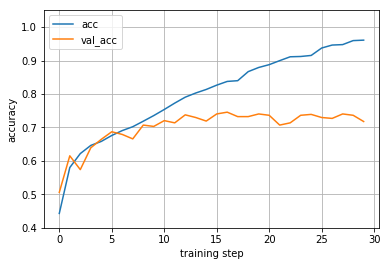

In [15]:
plot_hist(model)

## Standardize full dataset pixel-wise

Given:

- $X^{i}$: image $i$
- $X^{i}_{j|k}$: channel $k$ of pixel $j$ in image $i$
- $S^i$: image $i$ standardized

In pixel wise standardization, each pixel has zero mean and std=1 across the dataset:

- $\mu_{j|k} = \frac{1}{N}\sum_{i=0}^{N-1}X^{i}_{j|k}$
- $\sigma_{j|k} = \frac{1}{N}\sum_{i=0}^{N-1}(X^{i}_{j|k}-\mu_{j|k})^2$

So that:

$$S^{i}_{j|k} = \frac{1}{\sigma_{j|k}}(X^{i}_{j|k} - \mu_{j|k})$$

Observe that we compute one $\mu$ and one $\sigma$ per each pixel and channel across the dataset.

In [16]:
from sklearn.preprocessing import StandardScaler

sx_train = StandardScaler().fit_transform(x_train.reshape(-1,32*32*3)).reshape(-1,32,32,3)
sx_test  = StandardScaler().fit_transform(x_test.reshape(-1,32*32*3)).reshape(-1,32,32,3)


In [17]:
np.min(sx_train), np.max(sx_train)

(-2.471039009824585, 2.4466442843134684)

In [18]:
x_train.shape, sx_train.shape

((2253, 32, 32, 3), (2253, 32, 32, 3))

In [19]:
smodel = get_conv_model_A(num_classes)
train(smodel, sx_train, y_train, sx_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 2s 963us/sample - loss: 0.9377 - acc: 0.5295 - val_loss: 0.8386 - val_acc: 0.6165
Epoch 2/30
2253/2253 [==============================] - 2s 684us/sample - loss: 0.7683 - acc: 0.6569 - val_loss: 0.7576 - val_acc: 0.6605
Epoch 3/30
2253/2253 [==============================] - 2s 704us/sample - loss: 0.6840 - acc: 0.6889 - val_loss: 0.7353 - val_acc: 0.6751
Epoch 4/30
2253/2253 [==============================] - 2s 667us/sample - loss: 0.6268 - acc: 0.7257 - val_loss: 0.7091 - val_acc: 0.6884
Epoch 5/30
2253/2253 [==============================] - 2s 681us/sample - loss: 0.5347 - acc: 0.7625 - val_loss: 0.6676 - val_acc: 0.7297
Epoch 6/30
2253/2253 [==============================] - 2s 685us/sample - loss: 0.4738 - acc: 0.7994 - val_loss: 0.6467 - val_acc: 0.7443
Epoch 7/30
2253/2253 [==============================] - 2s 683us/sample - loss: 0.4137 - acc: 0.8256 - val_lo

{'loss': 1.6736937845435822, 'acc': 0.7310253}

Text(0.5, 1.0, 'pixel wise standardization')

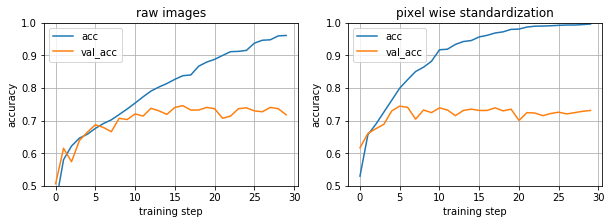

In [20]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plot_hist(model); plt.ylim(0.5,1); plt.title("raw images")
plt.subplot(122)
plot_hist(smodel); plt.ylim(0.5,1); plt.title("pixel wise standardization")

## Standardize each image

each image has zero mean and std=1 

In image wise standardization, each image has zero mean and std=1 across the dataset:

- $\mu^i = \frac{1}{n_j \times n_k}\sum_{j,k}X^{i}_{j|k}$
- $\sigma^i = \frac{1}{n_j \times n_k}\sum_{j,k}(X^{i}_{j|k}-\mu^i)^2$

where $n_j$ and $n_k$ are the number of pixels and the number of channels in im age $i$.

So that:

$$S^{i}_{j|k} = \frac{1}{\sigma^i}(X^{i}_{j|k} - \mu^i)$$


In [21]:
sc = StandardScaler()
sx_train = np.r_[[(i-np.mean(i))/np.std(i) for i in x_train]]
sx_test = np.r_[[(i-np.mean(i))/np.std(i) for i in x_test]]

np.min(sx_train), np.max(sx_train)

(-11.305667332993796, 5.7643374496543744)

In [22]:
s2model = get_conv_model_A(num_classes)
train(s2model, sx_train, y_train, sx_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 2s 981us/sample - loss: 0.8581 - acc: 0.6019 - val_loss: 0.7942 - val_acc: 0.6445
Epoch 2/30
2253/2253 [==============================] - 2s 688us/sample - loss: 0.6990 - acc: 0.6995 - val_loss: 0.7296 - val_acc: 0.6884
Epoch 3/30
2253/2253 [==============================] - 2s 670us/sample - loss: 0.6140 - acc: 0.7479 - val_loss: 0.6428 - val_acc: 0.7337
Epoch 4/30
2253/2253 [==============================] - 2s 676us/sample - loss: 0.5011 - acc: 0.7989 - val_loss: 0.6259 - val_acc: 0.7443
Epoch 5/30
2253/2253 [==============================] - 2s 690us/sample - loss: 0.4169 - acc: 0.8433 - val_loss: 0.6789 - val_acc: 0.7270
Epoch 6/30
2253/2253 [==============================] - 2s 687us/sample - loss: 0.3612 - acc: 0.8660 - val_loss: 0.6436 - val_acc: 0.7443
Epoch 7/30
2253/2253 [==============================] - 2s 681us/sample - loss: 0.2845 - acc: 0.9055 - val_lo

{'loss': 1.4909576547447438, 'acc': 0.73502}

Observe how accuracy (on train data) raises faster. Variance is still high since we have a small dataset.

- why does it raise faster on pixel-wise standardization?
- why does it raise even faster with image-wise standardization?

In both cases we are helping optimization by keeping activations centered in zero and having more meaningful gradients. In image-wise standardization we ensure this property tighter at each image.

Text(0.5, 1.0, 'image wise standardization')

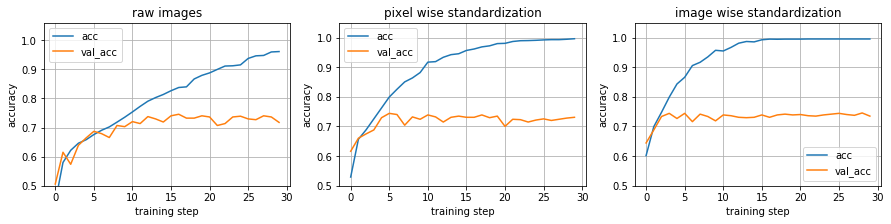

In [23]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plot_hist(model); plt.ylim(0.5,1.06); plt.title("raw images")
plt.subplot(132)
plot_hist(smodel); plt.ylim(0.5,1.05); plt.title("pixel wise standardization")
plt.subplot(133)
plot_hist(s2model); plt.ylim(0.5,1.05); plt.title("image wise standardization")

## ZCA whitening

In [24]:
def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs)   #Data whitening

In [25]:
sx_train = np.r_[[(i-np.mean(i))/np.std(i) for i in x_train]]
sx_test = np.r_[[(i-np.mean(i))/np.std(i) for i in x_test]]

zx_train = np.r_[[zca_whitening(i.reshape(1,-1)).reshape(i.shape) for i in sx_train]]
zx_test  = np.r_[[zca_whitening(i.reshape(1,-1)).reshape(i.shape) for i in sx_test]]


In [26]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
#zx_train = np.r_[[mm.fit_transform(i.reshape(-1,1)).reshape(i.shape) for i in zx_train]]
#zx_test = np.r_[[mm.fit_transform(i.reshape(-1,1)).reshape(i.shape) for i in zx_test]]

In [27]:
idxs = np.random.permutation(100)[:10]

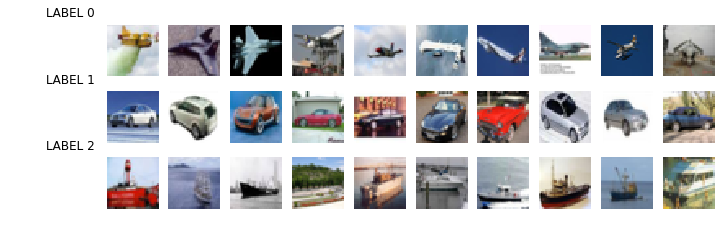

In [28]:
mlutils.show_labeled_image_mosaic(x_train, y_train, idxs=idxs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

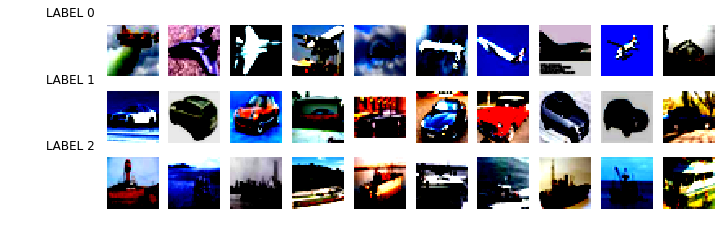

In [29]:
mlutils.show_labeled_image_mosaic(zx_train, y_train, idxs=idxs)

In [30]:
zmodel = get_conv_model_A(num_classes)
train(zmodel, zx_train, y_train, zx_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.8469 - acc: 0.6036 - val_loss: 0.7291 - val_acc: 0.6871
Epoch 2/30
2253/2253 [==============================] - 2s 680us/sample - loss: 0.6398 - acc: 0.7372 - val_loss: 0.6558 - val_acc: 0.7284
Epoch 3/30
2253/2253 [==============================] - 2s 677us/sample - loss: 0.5389 - acc: 0.7750 - val_loss: 0.7025 - val_acc: 0.6951
Epoch 4/30
2253/2253 [==============================] - 2s 676us/sample - loss: 0.4468 - acc: 0.8167 - val_loss: 0.6550 - val_acc: 0.7284
Epoch 5/30
2253/2253 [==============================] - 2s 677us/sample - loss: 0.3677 - acc: 0.8584 - val_loss: 0.7338 - val_acc: 0.7190
Epoch 6/30
2253/2253 [==============================] - 2s 689us/sample - loss: 0.2728 - acc: 0.9015 - val_loss: 0.7170 - val_acc: 0.7403
Epoch 7/30
2253/2253 [==============================] - 2s 676us/sample - loss: 0.1965 - acc: 0.9268 - val_loss

{'loss': 1.4076535366822813, 'acc': 0.76697737}

Text(0.5, 1.0, 'zca whitening')

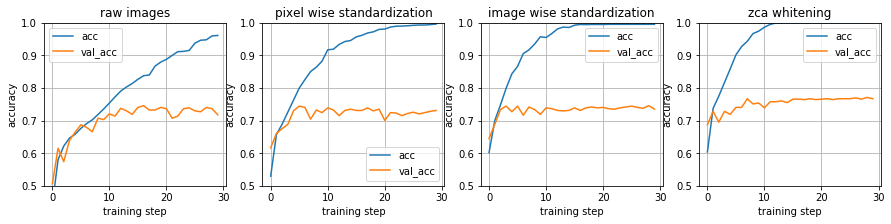

In [31]:
plt.figure(figsize=(15,3))
plt.subplot(141)
plot_hist(model); plt.ylim(0.5,1); plt.title("raw images")
plt.subplot(142)
plot_hist(smodel); plt.ylim(0.5,1); plt.title("pixel wise standardization")
plt.subplot(143)
plot_hist(s2model); plt.ylim(0.5,1); plt.title("image wise standardization")
plt.subplot(144)
plot_hist(zmodel); plt.ylim(0.5,1); plt.title("zca whitening")

Text(0, 0.5, 'accuracy in train')

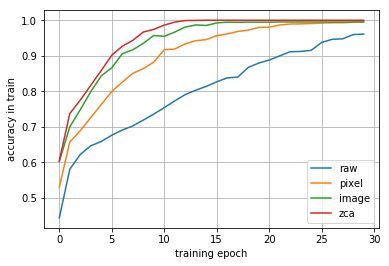

In [32]:
plt.plot(model.history.history["acc"], label="raw");
plt.plot(smodel.history.history["acc"], label="pixel");
plt.plot(s2model.history.history["acc"], label="image");
plt.plot(zmodel.history.history["acc"], label="zca");
plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("accuracy in train")

In [35]:
def get_conv_model_B(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(4,4), activation="relu")(inputs)
    layers = tf.keras.layers.BatchNormalization()(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [36]:
bmodel = get_conv_model_B(num_classes)
train(bmodel, x_train, y_train, x_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.9015 - acc: 0.6245 - val_loss: 0.9708 - val_acc: 0.5912
Epoch 2/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.5411 - acc: 0.7634 - val_loss: 0.9138 - val_acc: 0.6272
Epoch 3/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.3556 - acc: 0.8518 - val_loss: 0.8615 - val_acc: 0.6445
Epoch 4/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.2507 - acc: 0.9046 - val_loss: 0.7578 - val_acc: 0.6897
Epoch 5/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.1559 - acc: 0.9436 - val_loss: 0.7593 - val_acc: 0.6818
Epoch 6/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.1159 - acc: 0.9601 - val_loss: 0.7430 - val_acc: 0.7177
Epoch 7/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.0732 - acc: 0.9760 - val_loss: 0.7808 - v

{'loss': 1.529055150625074, 'acc': 0.747004}

Text(0, 0.5, 'accuracy in train')

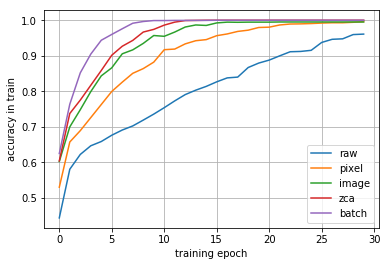

In [38]:
plt.plot(model.history.history["acc"], label="raw");
plt.plot(smodel.history.history["acc"], label="pixel");
plt.plot(s2model.history.history["acc"], label="image");
plt.plot(zmodel.history.history["acc"], label="zca");
plt.plot(bmodel.history.history["acc"], label="batch");
plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("accuracy in train")

observe that batch normalization by itself is, in this case, enough

In [39]:
bzmodel = get_conv_model_B(num_classes)
train(bzmodel, zx_train, y_train, zx_test, y_test, batch_size=32, epochs=30, model_name="model_A")

using 3 classes
Train on 2253 samples, validate on 751 samples
Epoch 1/30
2253/2253 [==============================] - 3s 2ms/sample - loss: 1.2118 - acc: 0.5797 - val_loss: 0.8970 - val_acc: 0.6298
Epoch 2/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.6401 - acc: 0.7581 - val_loss: 0.7909 - val_acc: 0.7017
Epoch 3/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.3960 - acc: 0.8362 - val_loss: 0.7794 - val_acc: 0.7111
Epoch 4/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.2476 - acc: 0.8961 - val_loss: 0.7959 - val_acc: 0.7097
Epoch 5/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.1580 - acc: 0.9463 - val_loss: 0.8599 - val_acc: 0.7137
Epoch 6/30
2253/2253 [==============================] - 4s 2ms/sample - loss: 0.1159 - acc: 0.9596 - val_loss: 0.9336 - val_acc: 0.6977
Epoch 7/30
2253/2253 [==============================] - 3s 1ms/sample - loss: 0.0792 - acc: 0.9747 - val_loss: 1.0246 - v

{'loss': 1.5094163161460632, 'acc': 0.7150466}

Text(0, 0.5, 'accuracy in train')

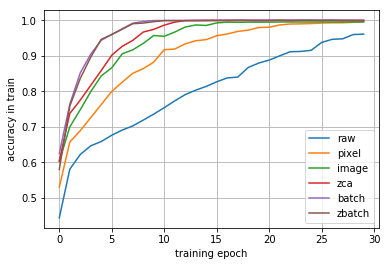

In [40]:
plt.plot(model.history.history["acc"], label="raw");
plt.plot(smodel.history.history["acc"], label="pixel");
plt.plot(s2model.history.history["acc"], label="image");
plt.plot(zmodel.history.history["acc"], label="zca");
plt.plot(bmodel.history.history["acc"], label="batch");
plt.plot(bzmodel.history.history["acc"], label="zbatch");
plt.grid();
plt.legend();
plt.xlabel("training epoch")
plt.ylabel("accuracy in train")